**Asian Options** is a type of financial derivative which derives it payoff from the average price of the underlying asset over a specified period of time rather than the spot price at maturity. This averaging mechanism makes Asian options particularly appealing in volatile markets where prices can fluctuate significantly over time.

One of the tools that I have learnt for Asian Options pricing is **Monte Carlo simulations** assuming that the model under consideration follows the Black-Scholes model. This is done by generating random paths for the asset price and then computing the average price over the option's lifespan to arrive at the final payoff.

Another approach that I have learnt is using **linear programming** to solve this problem. This is done by maximising the objective function which is a weighted sum of probable values of the option's price using scipy.stats to find the optimal probability matrix which when combined by certain weights give the final payoff value.


In [ ]:
'''Asian Options pricing with linear programming'''

import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats

n = 15
sig = 1
currentp = 1
strikep = 1
t1 = 0.5
t2 = 1
rm = 6
m = rm*n
en_g = 2/n
alp = np.zeros(m)
bet = np.zeros(m)
delt = np.zeros(m)
x = np.zeros(m*m)
for i in range(0,m):
    for j in range(0,m):
        x[i*m+j] = 0.00000001
def cxy(i,j):
    return abs((i+j)/(2*n)-strikep)

def bsm_call_value(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call_value = S0 * stats.norm.cdf(d1) - np.exp(-r * T) * K * stats.norm.cdf(d2)
    return call_value

def abalpha(i):
    if i==1:
        return (n*(bsm_call_value(currentp, (i+1)/n, t1, 0, sig) + currentp - 2*bsm_call_value(currentp, i/n, t1, 0, sig)))
    else:
        return (n*(bsm_call_value(currentp, (i+1)/n, t1, 0, sig) + bsm_call_value(currentp, (i-1)/n, t1, 0, sig) - 2*bsm_call_value(currentp, i/n, t1, 0, sig)))

def abbeta(i):
    if i==1:
        return (n*(bsm_call_value(currentp, (i+1)/n, t2, 0, sig) + currentp - 2*bsm_call_value(currentp, i/n, t2, 0, sig)))
    else:
        return (n*(bsm_call_value(currentp, (i+1)/n, t2, 0, sig) + bsm_call_value(currentp, (i-1)/n, t2, 0, sig) - 2*bsm_call_value(currentp, i/n, t2, 0, sig)))

alp[0] = 1
bet[0] = 1
for i in range(1,m):
    alp[i] = abalpha(i)
    alp[0] = alp[0] - alp[i]
    bet[i] = abbeta(i)
    bet[0] = bet[0] - bet[i]

def constraint1(x):
    for i in range(0,m):
        for j in range(0,m):
            bet[i] = bet[i] - x[j*m+i]
    return bet

def constraint2(x):
    for i in range(0,m):
        for j in range(0,m):
            alp[i] = alp[i] - x[i*m+j]
    return alp

def constraint4(x):
    en_g = 2/n
    for i in range(0,m):
        newsum = 0
        for j in range(0,m):
            newsum = newsum + x[i*m+j]*(j-i)/n
        delt[i] = abs(newsum)
        en_g = en_g - delt[i]
    return en_g

def objective(x):
    sum = 0
    for i in range(0,m):
        for j in range(0,m):
            sum = sum + x[i*m+j]*cxy(i,j)
    return (-sum)
b = (0.0, 1.0)
bnds = (b,)*m*m
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con4 = {'type': 'ineq', 'fun': constraint4}
conset1 = [con1, con2, con4]

sol = minimize(objective, x,method="SLSQP",bounds=bnds, constraints=conset1)
x = sol.x
finalprice = sol.fun
print('Payoff: ',abs(finalprice))

In [ ]:
'''using gurobi'''

import numpy as np
from gurobipy import Model, GRB, quicksum

# Parameters
n = 15
sig = 1
currentp = 1
strikep = 1
t1 = 0.5
t2 = 1
rm = 6
m = rm * n
en_g = 2 / n
alp = np.zeros(m)
bet = np.zeros(m)
x = np.zeros((m,m))
for i in range(0,m):
    for j in range(0,m):
        x[i, j] = 0.00000001

def cxy(i,j):
    return abs((i+j)/(2*n)-strikep)

# Precomputations
def bsm_call_value(S0, K, T, r, sigma):
    from scipy.stats import norm
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def abalpha(i):
    if i == 1:
        return n * (bsm_call_value(currentp, (i + 1) / n, t1, 0, sig) + currentp - 2 * bsm_call_value(currentp, i / n, t1, 0, sig))
    else:
        return n * (bsm_call_value(currentp, (i + 1) / n, t1, 0, sig) + bsm_call_value(currentp, (i - 1) / n, t1, 0, sig) - 2 * bsm_call_value(currentp, i / n, t1, 0, sig))

def abbeta(i):
    if i == 1:
        return n * (bsm_call_value(currentp, (i + 1) / n, t2, 0, sig) + currentp - 2 * bsm_call_value(currentp, i / n, t2, 0, sig))
    else:
        return n * (bsm_call_value(currentp, (i + 1) / n, t2, 0, sig) + bsm_call_value(currentp, (i - 1) / n, t2, 0, sig) - 2 * bsm_call_value(currentp, i / n, t2, 0, sig))

def cxy(i, j):
    return abs((i + j) / (2 * n) - strikep)

# Alpha and Beta setup
alp[0] = 1
bet[0] = 1
for i in range(1,m):
    alp[i] = abalpha(i)
    alp[0] = alp[0] - alp[i]
    bet[i] = abbeta(i)
    bet[0] = bet[0] - bet[i]

# Gurobi Model
model = Model("Asian Option Pricing")
x = model.addVars(m, m, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="x")

# Objective: Minimize -sum(x[i, j] * cxy(i, j))
model.setObjective(quicksum(x[i, j] * cxy(i, j) for i in range(m) for j in range(m)), GRB.MINIMIZE)

# Constraint 1: Beta constraint
for i in range(m):
    model.addConstr(quicksum(x[j, i] for j in range(m)) <= bet[i], f"Beta_{i}")

# Constraint 2: Alpha constraint
for i in range(m):
    model.addConstr(quicksum(x[i, j] for j in range(m)) <= alp[i], f"Alpha_{i}")

# Constraint 4: Delta constraint
for i in range(m):
    model.addConstr(quicksum(abs(x[i, j] * (j - i) / n) for j in range(m) for i in range(m)) <= en_g, f"Delta_{i}")

# Solve the model
model.optimize()

# Extract results
if model.status == GRB.OPTIMAL:
    solution = model.getAttr("X", x)
    finalprice = model.ObjVal
    print("Payoff:", abs(finalprice))
else:
    print("No optimal solution found.")


In [ ]:
'''Asian Options pricing with Monte Carlo Simulations'''

import numpy as np
import math
import scipy.stats as stats
S = 1 #current stock price
T = 1 #time to maturity
r = 0 #risk-free rate of return
sigma = 1 #volatility
K = 1 #strike price
Nsim = 50000 #number of simulations
Nsteps = 250 #number of time steps
dt = T/Nsteps #time step
drift = (r - 0.5*sigma**2)*dt #drift term
vol = sigma*math.sqrt(dt) #volatility term
x = np.random.normal(0,1,(Nsim,Nsteps)) #random normal variates
Smat = np.zeros((Nsim,Nsteps)) #matrix to store stock prices
Smat[:,0] = S #initial stock price
op = np.zeros(Nsim) #option price
for i in range(1,Nsteps):
    Smat[:,i] = Smat[:,i-1]*np.exp(drift + vol*x[:,i]) #stock price at time t
for i in range(Nsim):
  op[i] = np.average(Smat[i,:])
  if op[i] < K:
    op[i] = 0
  else:
    op[i] = op[i] - K
  op[i] = np.exp(-r*T)*op[i]
print('Strike price: ',K)
print('Option payoff: ',np.average(op))

Strike price:  1
Option payoff:  0.22723935698454722


In [ ]:
import pandas as pd
table = [[0.22723935698454722,0,0,0], [5,10,15,20], [15.732241848864678,61.13714878047778,137.04980023579301,405.15922969843814], [74.87195371514376,0,0,0], [234.80769387609254,0,0,0], [896.2449015379138,0,0,0], [1735.2431747242374,0,0,0], [2966.678444809521,0,0,0]]
df = pd.DataFrame(table, columns=['Payoff','Payoff','Payoff','Payoff'], index=['MC', 'n = ', 'rm = 2', 'rm = 3','rm = 4','rm = 5','rm = 6','rm = 7'])
print(df)


             Payoff     Payoff    Payoff  Payoff
MC         0.227239   0.000000    0.0000       0
n =        5.000000  10.000000   15.0000      20
rm = 2    15.732242  61.137149  137.0498       0
rm = 3    74.871954   0.000000    0.0000       0
rm = 4   234.807694   0.000000    0.0000       0
rm = 5   896.244902   0.000000    0.0000       0
rm = 6  1735.243175   0.000000    0.0000       0
rm = 7  2966.678445   0.000000    0.0000       0


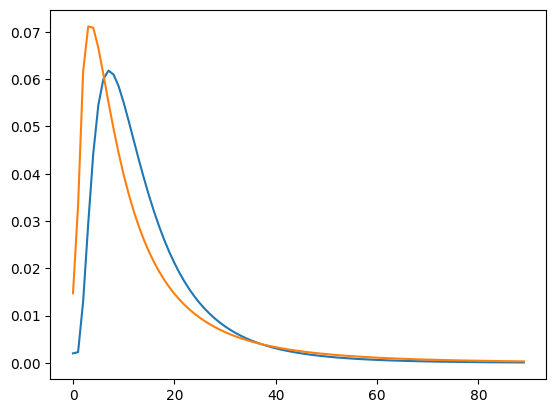

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

n = 15
sig = 1
currentp = 1
strikep = 1
t1 = 0.5
t2 = 1
rm = 6
m = rm*n
en_g = 2/n
alp = np.zeros(m)
bet = np.zeros(m)
xaxis = np.arange(0,m,1)

def bsm_call_value(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call_value = S0 * stats.norm.cdf(d1) - np.exp(-r * T) * K * stats.norm.cdf(d2)
    return call_value

def abalpha(i):
    if i==1:
        return (n*(bsm_call_value(currentp, (i+1)/n, t1, 0, sig) + currentp - 2*bsm_call_value(currentp, i/n, t1, 0, sig)))
    else:
        return (n*(bsm_call_value(currentp, (i+1)/n, t1, 0, sig) + bsm_call_value(currentp, (i-1)/n, t1, 0, sig) - 2*bsm_call_value(currentp, i/n, t1, 0, sig)))

def abbeta(i):
    if i==1:
        return (n*(bsm_call_value(currentp, (i+1)/n, t2, 0, sig) + currentp - 2*bsm_call_value(currentp, i/n, t2, 0, sig)))
    else:
        return (n*(bsm_call_value(currentp, (i+1)/n, t2, 0, sig) + bsm_call_value(currentp, (i-1)/n, t2, 0, sig) - 2*bsm_call_value(currentp, i/n, t2, 0, sig)))

alp[0] = 1
bet[0] = 1
for i in range(1,m):
    alp[i] = abalpha(i)
    alp[0] = alp[0] - alp[i]
    bet[i] = abbeta(i)
    bet[0] = bet[0] - bet[i]

plt.plot(xaxis,alp)
plt.plot(xaxis,bet)
plt.show()